In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv
from sklearn import cluster

In [3]:
class Location:
    def __init__(self, name=None, distance=None, river=None, distance_cluster=None):
        self.name = name
        self.distance = distance
        self.river = river
        self.cluster = cluster

In [4]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list, boat_list_amazonas, boat_list_negro, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        self.location.distance = distance[self.location.name][0]
        self.location.river = distance[self.location.name][1]
        self.location.cluster = distance_SB[self.location.name][2]
        

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        #print('%7.4f Call %d received from %s at a distance of %d on the river %s at a distance of the small base %d on the cluster %d' % (env.now, self.ID, self.location.name, self.location.distance, self.location.river, distance_SB[self.location.name][0], self.location.cluster))
        #print("temps estimé dans la version initiale : {}".format(2*(self.location.distance/boat_list[0].speed) + 0.25))
        if(self.location.river == "amazonas"): 
            yield env.process(trajet(env, boat_list, boat_list_amazonas, AB, SB_amazonas, "cluster_amazonas", self, distance_SB))       
        else: 
            yield env.process(trajet(env, boat_list, boat_list_negro, AB, SB_negro, "cluster_negro", self, distance_SB))
        
        self.status = 1
        

In [5]:
def trajet(env, boat_list, boat_list_river, AB, resource, cluster_name, self, distance_SB): 
    with resource.request() as req : 
        yield req
        time = 0 
        time_to_location = 0
        wait = env.now - self.initial_time #waiting time 
        start = env.now
        i = 0 
        if(boat_list_river[self.location.cluster].status == 0): 
            i = self.location.cluster
        else: 
            k = self.location.cluster-1 
            l = self.location.cluster+1
            if(k<0): 
                k = 0
            if(l == len(boat_list_river)): 
                l = len(boat_list_river)-1
            recherche = True 
            while(recherche):
                #print("k: {} l:{}".format(k,l))
                if(k>=0 or l<len(boat_list_river)):
                    plus_proche_base = min(distance_SB[cluster_name+str(boat_list_river[k].cluster)], 
                                           distance_SB[cluster_name+str(boat_list_river[l].cluster)])
                    if(plus_proche_base == distance_SB[cluster_name+str(boat_list_river[k].cluster)]): 
                        if(boat_list_river[k].status == 0):
                            recherche = False 
                            i = k
                        else: 
                            k = k-1
                    else: 
                        if(boat_list_river[l].status == 0):
                            recherche = False 
                            i = l
                        else: 
                            if(l != len(boat_list_river) - 1):
                                l =l+1
                            else: 
                                l = 0 
        #print('%7.4f Departure of the simple boat %s %d from cluster %d'%(env.now, self.location.river, boat_list_river[i].ID, boat_list_river[i].cluster))
        if(i != len(boat_list_river) and boat_list_river[i].status == 0):
            boat_list_river[i].status = 1
            if(boat_list_river[i].cluster == self.location.cluster): 
                time_to_location = distance_SB[self.location.name][0]/boat_list_river[i].speed
                time = time_to_location + self.location.distance/boat_list_river[i].speed
            else:
                time_to_location = abs(distance_SB[cluster_name+str(boat_list_river[i].cluster)] - 
                                       distance_SB[cluster_name+str(self.location.cluster)])/boat_list_river[i].speed + distance_SB[self.location.name][0]/boat_list_river[i].speed
                time = time_to_location + self.location.distance/boat_list_river[i].speed
            initial_AB = env.now
            with AB.request() as req_AB:
                yield req_AB
                wait_AB = env.now - initial_AB 
                #print('%7.4f Departure of the advanced boat'%(env.now))
                j = 0 
                while(j != len(boat_list) and boat_list[j].status != 0): #while you don't have a boat available 
                    j = j + 1
                if(j != len(boat_list) and boat_list[j].status == 0):
                    boat_list[j].status = 1
                    intervention = Intervention()
                    intervention.boat_SB = boat_list_river[i]
                    intervention.boat_AB = boat_list[j]
                    intervention.call = self
                    intervention.waited_time = wait 
                    intervention.TOS = 0.25
                    if(self.location.distance/boat_list[j].speed < distance_SB[self.location.name][0]/boat_list_river[i].speed):
                        t = 2*(self.location.distance/boat_list[j].speed)
                        boat_list_river[i].status = 0 
                        distance_to_base = distance_SB[cluster_name+str(boat_list_river[i].cluster)]
                    else:
                        if(env.now > start + time ): 
                            #print('appel traité par le boat simple')
                            distance_to_base = (env.now - start - time )*boat_list_river[i].speed
                            t = 0
                        else: 
                            reste = start + time - env.now #temps qu'il reste pour que le simple boat finisse le trajet 
                            if(reste<time-time_to_location): #si je suis déjà arrivé à la location et que je suis reparti  
                                d = reste*boat_list_river[i].speed #c'est la distance qu'il reste à parcourir au simple boat, autrement dit la distance entre le simple boat et la base principale 
                                t = 2*(d/(boat_list_river[i].speed + boat_list[j].speed))
                            else: #si je suis entre le cluster et la location 
                                d1 = (time_to_location-(time-reste))*boat_list[j].speed #(time - reste) represente la distance deja parcouru par le simple boat. Et comme reste > time-TTL, TTL-(time-reste) est positif
                                t = 2*(time_to_location-(time-reste)) + 2*((self.location.distance-d1)/(boat_list_river[i].speed + boat_list[j].speed)) #on fait distance-d1 car c'est la distance que l'AB a deja parcouru 
                            distance_to_base = boat_list[j].speed*(t/2)
                    #print("temps réel d'éxécution {}".format(t + intervention.TOS + wait_AB)) 
                    intervention.travel_time = t/2
                    intervention.response_time = intervention.travel_time + intervention.TOS
                    intervention.road_time = t + intervention.TOS + wait_AB
                    inter_list.append(intervention)
                    self.final_time = self.initial_time + intervention.road_time 
                    yield env.timeout(intervention.travel_time + intervention.TOS)
                    #print('%7.4f Call %d: echange en cours' % (env.now, self.ID))
                    echange = env.now
                    yield env.timeout(intervention.travel_time)
                    #print('%7.4f Call %d: Finished' % (env.now, self.ID))
                    boat_list[j].status = 0
        distance_to_cluster = abs(distance_SB[cluster_name+str(boat_list_river[i].cluster)] - distance_to_base)
        #print("distance_to_cluster : {}".format(distance_to_cluster))
        #print("temps prevu pour retour : {}".format(distance_to_cluster/boat_list_river[i].speed))
        if(env.now > echange + distance_to_cluster/boat_list_river[i].speed): 
            #print('%7.4f boat %s %d : déjà arrivée a la base'%(env.now, self.location.river, boat_list_river[i].ID))
            boat_list_river[i].status = 0 
        else:
            #print('%7.4f boat %s %d : en cours de retour a la base '%(env.now, self.location.river, boat_list_river[i].ID))
            distance_restante = abs(distance_to_cluster - (env.now - echange)*boat_list_river[i].speed)
            yield env.timeout(distance_restante/boat_list_river[i].speed)
            #print('%7.4f boat %s %d : arrivée a la base'%(env.now, self.location.river, boat_list_river[i].ID))
            boat_list_river[i].status = 0 

In [6]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat_SB=None, boat_AB=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat_SB = boat_SB
        self.boat_AB = boat_AB
        self.call = call
        
    def to_dict(self): 
        return {
            'Cluster du call': self.call.location.cluster,
            'Simple Boat': self.boat_SB.ID,
            'Cluster boat': self.boat_SB.cluster,
            'Advanced Boat': self.boat_AB.ID, 
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [7]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None, cluster=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 
        self.cluster = cluster

In [8]:
def clustering(distance, nb_boat_simple): 
    distance_negro = []
    distance_amazonas = []
    for i in range(len(distance)): #on regarde le fleuve de chaque location pour permettre de faire un cluster par bras de fleuve  
        if(distance[[*distance][i]][1] == 'amazonas'):
            distance_amazonas.append([0,distance[[*distance][i]][0]]) #on est obligé de mettre [0, distance] pour la fonction de clustering 
        else: 
            distance_negro.append([0,distance[[*distance][i]][0]])
    #on définit les paramètres du calcul des clusters 
    kmeans_negro = cluster.KMeans(n_clusters=nb_boat_simple, max_iter=1000) 
    kmeans_amazonas = cluster.KMeans(n_clusters=nb_boat_simple, max_iter=1000)
    
    #on réalise les calculs 
    kmeans_amazonas.fit(distance_amazonas)
    kmeans_negro.fit(distance_negro) 
    
    #on calcule pour chaque fleuve la distance des locations par rapport au nouveau centre 
    for i in range(len(kmeans_amazonas.labels_)): 
        distance_amazonas[i][1] = abs(distance_amazonas[i][1]-kmeans_amazonas.cluster_centers_[kmeans_amazonas.labels_[i]][1])
    for i in range(len(kmeans_negro.labels_)): 
        distance_negro[i][1] = abs(distance_negro[i][1]-kmeans_negro.cluster_centers_[kmeans_negro.labels_[i]][1])
        
    #on recrée le dictionnaire initial avec les nouvelles distances. Comme c'est dans le même ordre qu'à l'aller, le
    #dictionnaire se recrée tout seul automatiquement 
    distance_SB = {}
    for loc in [*distance]: 
        if(distance[loc][1] == 'amazonas'): 
            distance_SB[loc] = (distance_amazonas[0][1], 'amazonas', kmeans_amazonas.labels_[0])
            kmeans_amazonas.labels_ = np.delete(kmeans_amazonas.labels_, 0)
            del distance_amazonas[0] #on est obligé de faire pop l'élément pour pouvoir recréer le dictionnaire dans le même ordre
        else: 
            distance_SB[loc] = (distance_negro[0][1], 'negro', kmeans_negro.labels_[0])
            kmeans_negro.labels_ = np.delete(kmeans_negro.labels_, 0)
            del distance_negro[0]
    for i in range(len(kmeans_amazonas.cluster_centers_)): 
        distance_SB["cluster_amazonas"+str(i)] = kmeans_amazonas.cluster_centers_[i][1]
    for i in range(len(kmeans_negro.cluster_centers_)): 
        distance_SB["cluster_negro"+str(i)] = kmeans_negro.cluster_centers_[i][1]
    return(distance_SB)

In [9]:
def source(env, AB, SB_negro, SB_amazonas, distance_SB, p, boat_list, boat_list_amazonas, boat_list_negro, call_list, coeff_call): 
    yield env.timeout(0)
    #print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list, boat_list_amazonas, boat_list_negro))
        else: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list, boat_list_amazonas, boat_list_negro, call_list[i-1]))

In [10]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':(100, 'amazonas'), 'N SRA P. SOCORRO':(90, 'amazonas'), 'BONSUCESSO':(80, 'amazonas'), 
         'ASS. NAZARE':(70, 'amazonas'), 'GUAJARA':(60, 'negro'), 'ARUAU':(100, 'negro'), 'MIPINDIAU':(90, 'negro'), 'CUIEIRAS':(75, 'negro'), 
         'SANTA MARIA':(60, 'negro'), 'JARAQUI':(52, 'negro'), 'COSTA DOS ARARAS':(50, 'amazonas'), 
         'COSTA DO TATU':(30, 'negro'), 'AGROVILA':(20, 'negro'), 'N. SRA. FATIMA':(15, 'negro'), 'LIVRAMENTO':(15, 'negro')}
nb_boat_avanced = 1
nb_boat_simple = 5
nb_call = 164
nb_repet = 100
inter_list = []
df = []
call_list = []
interval = []
test = []


In [11]:
def model(nb_boat_simple, nb_boat_avanced, coeff, speed_AB, speed_SB):
    env = simpy.Environment()
    boat_list_amazonas = []
    boat_list_negro = []
    boat_list = []
    distance_SB = clustering(distance, nb_boat_simple)
    for i in range(nb_boat_avanced): 
        boat_list.append(Boat(env, speed_AB,0))
    for i in range(nb_boat_simple): 
        boat_list_amazonas.append(Boat(env,speed_SB,0,i))
        boat_list_negro.append(Boat(env,speed_SB,0,i))
    AB = simpy.Resource(env, capacity=nb_boat_avanced)
    SB_negro = simpy.Resource(env, capacity=nb_boat_simple)
    SB_amazonas = simpy.Resource(env, capacity=nb_boat_simple)
    env.process(source(env, AB, SB_negro, SB_amazonas, distance_SB, p_2015, boat_list, boat_list_amazonas, boat_list_negro, call_list, coeff))
    env.run()

In [12]:
#Allow to launch nb_repet of repetitions 
#simple boat modification 
coeff_call_list = [(i*2) for i in range(2, 20)]
speed_AB = 46
speed_SB = 30
for i in range(1, nb_boat_simple+1): 
    j = 0 
    for coeff in coeff_call_list:
        random.seed(42)
        np.random.seed(42)
        model(i, nb_boat_avanced, coeff, speed_AB, speed_SB)
        df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
        interval.append(df[j]["total time"].mean())
        
        print("lambda: {} temps total moyen: {} with {}".format(coeff, df[j]["total time"].mean(), i))
        #reset the global variables 
        inter_list = []
        call_list = []
        j = j + 1 
        
    test.append(interval)
    interval = []
    df = []

lambda: 4 temps total moyen: 2.5905635054737064 with 1
lambda: 6 temps total moyen: 2.5013034861101415 with 1
lambda: 8 temps total moyen: 2.5012137753158226 with 1
lambda: 10 temps total moyen: 2.4790092145563003 with 1
lambda: 12 temps total moyen: 2.4650703672944685 with 1
lambda: 14 temps total moyen: 2.4602558229514546 with 1
lambda: 16 temps total moyen: 2.45696516224627 with 1
lambda: 18 temps total moyen: 2.458160096778899 with 1
lambda: 20 temps total moyen: 2.453013908847523 with 1
lambda: 22 temps total moyen: 2.450871259280206 with 1
lambda: 24 temps total moyen: 2.449193486118832 with 1
lambda: 26 temps total moyen: 2.447515712957462 with 1
lambda: 28 temps total moyen: 2.4458904721642623 with 1
lambda: 30 temps total moyen: 2.4444765688745353 with 1
lambda: 32 temps total moyen: 2.443062665584806 with 1
lambda: 34 temps total moyen: 2.441648762295067 with 1
lambda: 36 temps total moyen: 2.4402348590053333 with 1
lambda: 38 temps total moyen: 2.438898466786755 with 1
lambd

In [13]:
#Allow to launch nb_repet of repetitions 
#simple boat modification 
coeff_call_list = [(i*2) for i in range(2, 20)]
speed_AB = 46
speed_SB = 30
inter = []
result = []
for i in range(1, nb_boat_simple+1): 
    for coeff in coeff_call_list: 
        for j in range(nb_repet):
            model(i, nb_boat_avanced, coeff, speed_AB, speed_SB)
            df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
            interval.append(df[j]["total time"].mean())
            inter_list = []
            call_list = []
        inter.append(sum(interval)/len(interval))
        print("lambda: {} temps total moyen: {} with {} simple boat(s)".format(coeff, sum(interval)/len(interval), i)) 
        interval = []
        df = []
    result.append(inter)
    inter = []

lambda: 4 temps total moyen: 2.3791634132712653 with 1 simple boat(s)
lambda: 6 temps total moyen: 2.3436172394351384 with 1 simple boat(s)
lambda: 8 temps total moyen: 2.3307371106692565 with 1 simple boat(s)
lambda: 10 temps total moyen: 2.3021780745499982 with 1 simple boat(s)
lambda: 12 temps total moyen: 2.274743345059094 with 1 simple boat(s)
lambda: 14 temps total moyen: 2.2992793059823207 with 1 simple boat(s)
lambda: 16 temps total moyen: 2.289312499513238 with 1 simple boat(s)
lambda: 18 temps total moyen: 2.2797323409226506 with 1 simple boat(s)
lambda: 20 temps total moyen: 2.2693965170552244 with 1 simple boat(s)
lambda: 22 temps total moyen: 2.2717312786908535 with 1 simple boat(s)
lambda: 24 temps total moyen: 2.26166253062861 with 1 simple boat(s)
lambda: 26 temps total moyen: 2.2769544488878504 with 1 simple boat(s)
lambda: 28 temps total moyen: 2.2706106993980946 with 1 simple boat(s)
lambda: 30 temps total moyen: 2.2643012655912527 with 1 simple boat(s)
lambda: 32 te

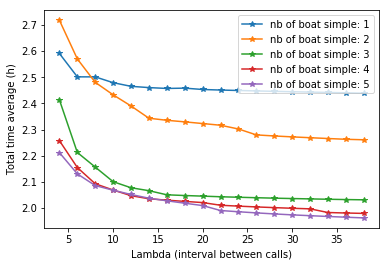

In [14]:
#simple boat modification 
for i in range(nb_boat_simple): 
    plt.plot(coeff_call_list, test[i], marker='*', label="nb of boat simple: {}".format(i+1))
plt.legend(loc="upper right")
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Total time average (h)')
plt.show()

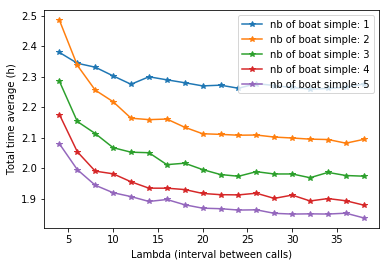

In [15]:
#simple boat modification 
for i in range(nb_boat_simple): 
    plt.plot(coeff_call_list, result[i], marker='*', label="nb of boat simple: {}".format(i+1))
plt.legend(loc="upper right")
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Total time average (h)')
plt.show()

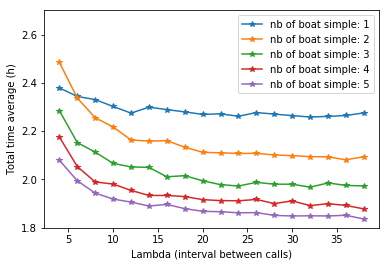

In [16]:
#simple boat modification 
for i in range(nb_boat_simple): 
    plt.plot(coeff_call_list, result[i], marker='*', label="nb of boat simple: {}".format(i+1))
axes = plt.gca()
plt.legend(loc="upper right")
axes.set_ylim(1.8, 2.7)
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Total time average (h)')
plt.show()

In [17]:
speed_list = [i*5 for i in range(1,18)]
coeff = 38
j = 0 
df = []
interval = []
inter_list = []
for i in speed_list:
    random.seed(42)
    np.random.seed(42)
    model(1, 1, coeff, i, 30)
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
    interval.append(df[j]["total time"].mean())
        
    print("lambda: {} temps d'intervention total moyen: {} speed:{}".format(coeff, df[j]["total time"].mean(), i))
    #reset the global variables 
    inter_list = []
    call_list = []
    j = j + 1 
    

lambda: 38 temps d'intervention total moyen: 5.212519171254688 speed:5
lambda: 38 temps d'intervention total moyen: 4.604467381595918 speed:10
lambda: 38 temps d'intervention total moyen: 4.110697477658635 speed:15
lambda: 38 temps d'intervention total moyen: 3.6771332171435485 speed:20
lambda: 38 temps d'intervention total moyen: 3.3326176463000055 speed:25
lambda: 38 temps d'intervention total moyen: 3.056726140285429 speed:30
lambda: 38 temps d'intervention total moyen: 2.83045827841909 speed:35
lambda: 38 temps d'intervention total moyen: 2.63873451949742 speed:40
lambda: 38 temps d'intervention total moyen: 2.470039441391758 speed:45
lambda: 38 temps d'intervention total moyen: 2.322701788981199 speed:50
lambda: 38 temps d'intervention total moyen: 2.192738342004643 speed:55
lambda: 38 temps d'intervention total moyen: 2.075963936333099 speed:60
lambda: 38 temps d'intervention total moyen: 1.965037585279891 speed:65
lambda: 38 temps d'intervention total moyen: 1.862261992770256 sp

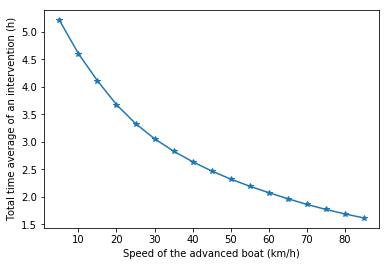

In [18]:
plt.plot(speed_list, interval, marker='*')
plt.xlabel('Speed of the advanced boat (km/h)')
plt.ylabel('Total time average of an intervention (h)')
plt.show()

In [19]:
speed_list = [i*5 for i in range(1,18)]
coeff = 38
j = 0 
df = []
interval = []
inter_list = []
for i in speed_list:
    random.seed(42)
    np.random.seed(42)
    model(1, 1, coeff, 46, i)
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
    interval.append(df[j]["total time"].mean())
        
    print("lambda: {} temps d'intervention total moyen: {} speed:{}".format(coeff, df[j]["total time"].mean(), i))
    #reset the global variables 
    inter_list = []
    call_list = []
    j = j + 1 
    

lambda: 38 temps d'intervention total moyen: 3.015979566570238 speed:5
lambda: 38 temps d'intervention total moyen: 2.9444876833624187 speed:10
lambda: 38 temps d'intervention total moyen: 2.82688884667641 speed:15
lambda: 38 temps d'intervention total moyen: 2.712071746949594 speed:20
lambda: 38 temps d'intervention total moyen: 2.5799657808021386 speed:25
lambda: 38 temps d'intervention total moyen: 2.438898466786755 speed:30
lambda: 38 temps d'intervention total moyen: 2.3128963736795543 speed:35
lambda: 38 temps d'intervention total moyen: 2.1983063112793855 speed:40
lambda: 38 temps d'intervention total moyen: 2.0969157383541486 speed:45
lambda: 38 temps d'intervention total moyen: 2.0064878589873425 speed:50
lambda: 38 temps d'intervention total moyen: 1.9253175867198835 speed:55
lambda: 38 temps d'intervention total moyen: 1.8519690222486458 speed:60
lambda: 38 temps d'intervention total moyen: 1.7853664030838694 speed:65
lambda: 38 temps d'intervention total moyen: 1.7246287996

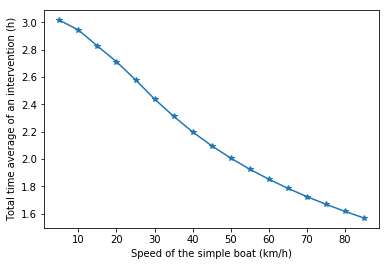

In [20]:
plt.plot(speed_list, interval, marker='*')
plt.xlabel('Speed of the simple boat (km/h)')
plt.ylabel('Total time average of an intervention (h)')
plt.show()

In [21]:
speed_list = [i*5 for i in range(2,18)]
coeff = 38
j = 0 
df = []
interval = []
for i in speed_list:
    random.seed(42)
    np.random.seed(42)
    model(1, 1, coeff, 46, i)
    df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
        
    interval.append(df[j]["waited time"].mean())
        
    print("lambda: {} temps d'attente moyen: {} speed:{}".format(coeff, df[j]["waited time"].mean(), i))
    #reset the global variables 
    inter_list = []
    call_list = []
    j = j + 1 

TypeError: model() missing 1 required positional argument: 'speed_SB'

In [ ]:
plt.plot(speed_list, interval, marker='*')
plt.xlabel('Speed of the boat (km/h)')
plt.ylabel('Waited time average (h)')
plt.show()

In [24]:
#Allow to launch nb_repet of repetitions 
#advanced boat modification 
coeff_call_list = [(i*2) for i in range(2, 20)]
speed_AB = 46
speed_SB = 30
inter = []
result = []
nb_boat_simple = 3
nb_boat_avanced = 5
for i in range(1, nb_boat_avanced+1): 
    for coeff in coeff_call_list: 
        for j in range(nb_repet):
            model(nb_boat_simple, i, coeff, speed_AB, speed_SB)
            df.append(pd.DataFrame.from_records([inter.to_dict() for inter in inter_list]))
            interval.append(df[j]["total time"].mean())
            inter_list = []
            call_list = []
        inter.append(sum(interval)/len(interval))
        print("lambda: {} temps total moyen: {} with {} simple boat(s)".format(coeff, sum(interval)/len(interval), i)) 
        interval = []
        df = []
    result.append(inter)
    inter = []

lambda: 4 temps total moyen: 2.2943068555298014 with 1 simple boat(s)
lambda: 6 temps total moyen: 2.1687328653742592 with 1 simple boat(s)
lambda: 8 temps total moyen: 2.096536638471031 with 1 simple boat(s)
lambda: 10 temps total moyen: 2.0582651358293482 with 1 simple boat(s)
lambda: 12 temps total moyen: 2.0535387894362467 with 1 simple boat(s)
lambda: 14 temps total moyen: 2.0274058623903626 with 1 simple boat(s)
lambda: 16 temps total moyen: 2.010358445553666 with 1 simple boat(s)
lambda: 18 temps total moyen: 2.002056388648856 with 1 simple boat(s)
lambda: 20 temps total moyen: 1.992032632334993 with 1 simple boat(s)
lambda: 22 temps total moyen: 1.9954464308701079 with 1 simple boat(s)
lambda: 24 temps total moyen: 1.9972197155981872 with 1 simple boat(s)
lambda: 26 temps total moyen: 1.981586163420559 with 1 simple boat(s)
lambda: 28 temps total moyen: 1.965592428773945 with 1 simple boat(s)
lambda: 30 temps total moyen: 1.9741792493343082 with 1 simple boat(s)
lambda: 32 temp

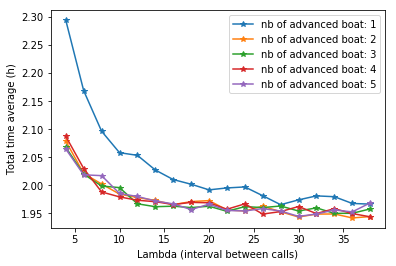

In [25]:
for i in range(nb_boat_avanced): 
    plt.plot(coeff_call_list, result[i], marker='*', label="nb of advanced boat: {}".format(i+1))
plt.legend(loc="upper right")
plt.xlabel('Lambda (interval between calls)')
plt.ylabel('Total time average (h)')
plt.show()